# Time Series Model for Annual Water Usage in Baltimore Using Python
### David Lowe
### January 30, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

Code Credit: Adapted from a blog post made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/time-series-forecast-study-python-annual-water-usage-baltimore/

PREFACE: This is a replication of Python code from Dr. Brownlee's blog post on time series. I have combined all the code snipets into one script, so I can turn the whole process into a template. The comments and analysis were also part of the blog post and annodated here to explain each coding block.

SUMMARY: The purpose of this project is to construct a time series prediction model and document the end-to-end steps using a template. The Annual Water Usage in Baltimore dataset is a time series situation where we are trying to forecast future outcomes based on the past data points.

INTRODUCTION: The problem is to predict annual water usage. The dataset provides the annual water usage in Baltimore from 1885 to 1963, or 79 years of data. The dataset contains 79 observations in the units of liters per capita per day and is credited to Hipel and McLeod, 1994.

ANALYSIS: The baseline prediction (or persistence) for the dataset resulted in an RMSE of 21.975. The manually configured model was simplified to ARIMA(4,1,1) and produced an RMSE of 31.097, which was higher than the persistent model. After applying the grid search technique to the dataset, the final RMSE of the ARIMA(2,1,0) model was 21.733. This is only a slightly smaller error than the persistent model, and it may or may not be statistically different.

CONCLUSION: The final RMSE for the validation period is predicted at 16 liters per capita per day. This is not too different from the expected error of 21, but we would expect that it is also not too different from a simple persistence model. The forecast does have the characteristics of a persistence forecast. This suggests that although this time series does have an obvious trend, it is still a reasonably difficult problem.

Dataset Used: Annual Water Usage in Baltimore

Dataset ML Model: Time series forecast with numerical attributes

Dataset Reference: https://datamarket.com/data/set/22sl/baltmore-city-annual-water-use-liters-per-capita-per-day-1885-1968#!ds=22sl&display=line

One potential source of performance benchmark: https://machinelearningmastery.com/time-series-forecast-study-python-annual-water-usage-baltimore/

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end
* Explore data cleaning and transformation options
* Explore various algorithms for baselining the model performance
* Explore tuning techniques for improving the model performance

A time series predictive modeling project genrally can be broken down into about five major tasks:

1. Define Problem and Acquire Data
2. Inspect and Explore Data
3. Clean and Pre-Process Data
4. Fit and Evaluate Models
5. Finalize and Deploy Model

## Section 1. Define Problem and Acquire Data

### 1.a) Load Libraries

In [1]:
import numpy as np
import pandas as pd
import smtplib
import warnings
from datetime import datetime
from email.message import EmailMessage
from math import exp
from math import log
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from pandas import Series
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error

# Create a random seed number variable for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = "luozhi2488@gmail.com"
    receiver = "dave@contactdavidlowe.com"
    with open('../email_credential.txt') as f:
        password = f.readline()
        f.close()
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Time Series Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender, password)
    server.send_message(msg)
    server.quit()

In [3]:
email_notify("Program Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

The dataset is not current. This means that we cannot easily collect updated data to validate the model. Therefore, we will pretend that it is 1953 and withhold the last 10 years of data from analysis and model selection. This final decade of data will be used to validate the final model.

The code below will load the dataset as a Pandas Series and split into two, one for model development (dataset.csv) and the other for validation (validation.csv). The specific contents of these files are:

* dataset.csv: Observations from 1885 to 1953 (69 observations).
* validation.csv: Observations from 1954 to 1963 (10 observations).

The validation dataset is about 12% of the original dataset.

In [4]:
startTimeScript = datetime.now()

In [5]:
# split into a training and validation dataset
series = read_csv('water.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 69, Validation 10


### 1.d) Establish the Persistent Model

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

Candidate models will be evaluated using walk-forward validation. This is because a rolling-forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data.

The walk-forward validation will work as follows:

* The first 50% of the dataset will be held back to train the model.
* The remaining 50% of the dataset will be iterated and test the model.
* For each step in the test dataset:
    * A model will be trained.
    * A one-step prediction made and the prediction stored for later evaluation.
    * The actual observation from the test dataset will be added to the training dataset for the next iteration.
* The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported.

Given the small size of the data, we will allow a model to be re-trained given all available data prior to each prediction.

In [6]:
# evaluate a persistence model
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=515
>Predicted=515.000, Expected=522
>Predicted=522.000, Expected=492
>Predicted=492.000, Expected=503
>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=450
>Predicted=450.000, Expected=432
>Predicted=432.000, Expected=432
>Predicted=432.000, Expected=458
>Predicted=458.000, Expected=462
>Predicted=462.000, Expected=503
>Predicted=503.000, Expected=488
>Predicted=488.000, Expected=466
>Predicted=466.000, Expected=492
>Predicted=492.000, Expected=503
>Predicted=503.000, Expected=515
>Predicted=515.000, Expected=500
>Predicted=500.000, Expected=522
>Predicted=522.000, Expected=575
>Predicted=575.000, Expected=583
>Predicted=583.000, Expected=587
>Predicted=587.000, Expected=628
>Predicted=628.000, Expected=640
>Predicted=640.000, Expected=609
>Predicted=609.000, Expected=606
>Predicted=606.000, Expected=632
>Predicted=632.000, Expected=617
>Predicted=617.000, Expected=613
>Predicted

In [7]:
email_notify("Program Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2. Inspect and Explore Data

In [8]:
email_notify("Data Inspection and Exploration has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics of the Time Series Data

Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with. Some observations from these statistics include:

* The number of observations (count) matches our expectation, meaning we are handling the data correctly.
* The mean is about 500, which we might consider our level in this series.
* The standard deviation and percentiles suggest a reasonably tight spread around the mean.

In [9]:
# summary statistics of time series
print(series.describe())

count     69.000000
mean     500.478261
std       73.901685
min      344.000000
25%      458.000000
50%      492.000000
75%      538.000000
max      662.000000
Name: 1, dtype: float64


### 2.b) Line Plot of the Time Series Data

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot include:

* There looks to be an increasing trend in water usage over time.
* There do not appear to be any obvious outliers, although there are some large fluctuations.
* There is a downward trend for the last few years of the series.

There may be some benefit in explicitly modeling the trend component and removing it. We may also explore using differencing with one or two levels in order to make the series stationary.

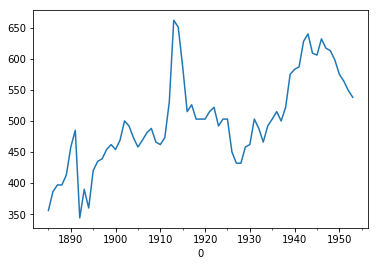

In [10]:
# line plots of time series
series.plot()
pyplot.show()

### 2.c) Density Plots of the Time Series Data

Reviewing plots of the density of observations can provide further insight into the structure of the data. Some observations from the plots include:

* The distribution is not Gaussian, but is pretty close.
* The distribution has a long right tail and may suggest an exponential distribution or a double Gaussian.

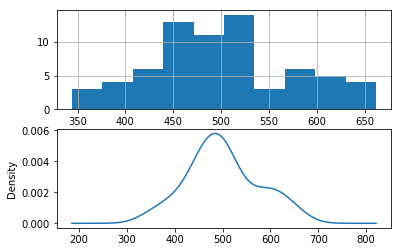

In [11]:
# density plots of time series
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

### 2.d) Box and Whisker Plots of the Time Series Data

We can group the monthly data by year and get an idea of the spread of observations for each year and how this may be changing. We do expect to see some trend (increasing mean or median), but it may be interesting to see how the rest of the distribution may be changing.

The last decade only contains 9 years and may not be a useful comparison with the other decades. Therefore only data between 1885 and 1944 was plotted.

Some observations from reviewing the plot include:

* The median values for each year (red line) may show an increasing trend that may not be linear.
* The spread, or middle 50% of the data (blue boxes), does show some variability.
* There maybe outliers in some decades (crosses outside of the box and whiskers).
* The second to last decade seems to have a lower average consumption, perhaps related to the first world war.

This yearly view of the data is an interesting avenue and could be pursued further by looking at summary statistics from decade-to-decade and changes in summary statistics.

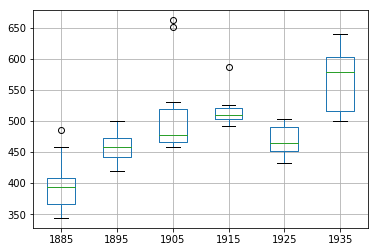

In [12]:
# boxplots of time series
groups = series.groupby(Grouper(freq='10YS'))
decades = DataFrame()
for name, group in groups:
	if len(group.values) is 10:
		decades[name.year] = group.values
decades.boxplot()
pyplot.show()

In [13]:
email_notify("Data Inspection and Exploration completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3. Clean and Pre-Process Data

This section currently is not applicable to this iteration of the project.

In [14]:
email_notify("Data Cleaning and Pre-Processing has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [15]:
email_notify("Data Cleaning and Pre-Processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 4. Fit and Evaluate Models

In this section, we will develop Autoregressive Integrated Moving Average or ARIMA models for the problem. We will approach modeling by both manual and automatic configuration of the ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model.

* Manually Configure the ARIMA.
* Automatically Configure the ARIMA.
* Review Residual Errors.

In [16]:
email_notify("Model Fitting and Evaluation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Manually Configured ARIMA

In [17]:
email_notify("Performing Manual ARIMA has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

#### 4.a.i) Statistical Test for the Stationarity of the Time Series Data

The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually. Analysis of the time series data assumes that we are working with a stationary time series.

The time series is likely non-stationary. We can make it stationary by first differencing the series and using a statistical test to confirm that the result is stationary.

The results show that the test statistic value -6.126719 is smaller than the critical value at 1% of -3.534. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. This suggests that at least one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1.

ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


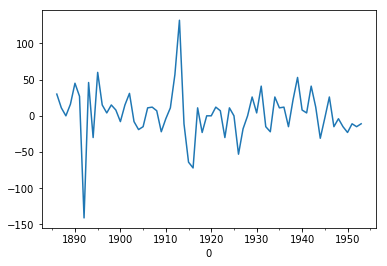

In [18]:
# create a differenced series
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)

X = series.values
X = X.astype('float32')
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
pyplot.show()
# save
stationary.to_csv('stationary.csv')

#### 4.a.ii) ACF and PACF Plots of the Time Series Data

The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

Below are some observations from the plots.

* The ACF shows significant lags to 4 time steps.
* The PACF shows significant lags to 1 time step.

A good starting point for the p is 4 and q as 1.

C:\Users\david.lowe\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


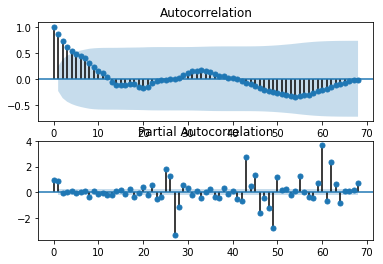

In [19]:
# ACF and PACF plots of time series
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

#### 4.a.iii) Evaluate Manually Configured ARIMA Model

A quick analysis from ACF and PACF suggests an ARIMA(4,1,1) on the raw data may be a good starting point.

Running this example results in an RMSE of 31.097, which is higher than the persistence model above. This may be because of the details of the ARIMA implementation, such as an automatic trend constant that is calculated and added.

In [20]:
# evaluate manually configured ARIMA model
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(4,1,1))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=548.319, Expected=503
>Predicted=545.085, Expected=503
>Predicted=546.061, Expected=515
>Predicted=550.660, Expected=522
>Predicted=552.011, Expected=492
>Predicted=519.221, Expected=503
>Predicted=527.953, Expected=503
>Predicted=534.026, Expected=450
>Predicted=474.118, Expected=432
>Predicted=456.458, Expected=432
>Predicted=465.408, Expected=458
>Predicted=481.425, Expected=462
>Predicted=476.155, Expected=503
>Predicted=511.083, Expected=488
>Predicted=497.183, Expected=466
>Predicted=460.301, Expected=492
>Predicted=506.310, Expected=503
>Predicted=515.928, Expected=515
>Predicted=516.368, Expected=500
>Predicted=504.364, Expected=522
>Predicted=525.885, Expected=575
>Predicted=579.358, Expected=583
>Predicted=575.313, Expected=587
>Predicted=573.357, Expected=628
>Predicted=622.135, Expected=640
>Predicted=632.300, Expected=609
>Predicted=595.782, Expected=606
>Predicted=602.447, Expected=632
>Predicted=635.946, Expected=617
>Predicted=614.238, Expected=613
>Predicted

In [21]:
email_notify("Performing Manual ARIMA completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.b) Grid Search of ARIMA Hyperparameters

The ACF and PACF plots suggest that we cannot do better than a persistence model on this dataset. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters and check that no models result in better out of sample RMSE performance.

In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values.

Specifically, we will search all combinations of the following parameters:

p: 0 to 4.
d: 0 to 2.
q: 0 to 4.

This is (5 * 3 * 5), or 300 potential runs of the test harness, and will take some time to execute.

We will also disable the automatic addition of a trend constant from the model by setting the ‘trend‘ argument to ‘nc‘ for no constant when calling fit().

The results show that the best configuration discovered was ARIMA(2, 1, 0) with an RMSE of 21.733, slightly lower than the manual persistence model tested earlier, but may or may not be significantly different. We will select this ARIMA(2, 1, 0) model going forward.

In [22]:
email_notify("ARIMA Hyperparameters Search has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [23]:
# grid search ARIMA parameters for a time series
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		# model_fit = model.fit(disp=0)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=282.658
ARIMA(0, 0, 4) RMSE=77.303
ARIMA(0, 1, 1) RMSE=21.907
ARIMA(0, 1, 2) RMSE=22.182
ARIMA(0, 1, 3) RMSE=24.733
ARIMA(0, 1, 4) RMSE=24.845
ARIMA(0, 2, 1) RMSE=22.381
ARIMA(0, 2, 2) RMSE=22.244
ARIMA(1, 0, 0) RMSE=21.852
ARIMA(1, 1, 0) RMSE=21.922
ARIMA(1, 2, 0) RMSE=27.464
ARIMA(1, 2, 1) RMSE=22.271
ARIMA(2, 1, 0) RMSE=21.733
ARIMA(2, 2, 0) RMSE=25.282
ARIMA(3, 1, 0) RMSE=24.270
ARIMA(3, 1, 1) RMSE=25.491
ARIMA(3, 2, 0) RMSE=25.625
ARIMA(3, 2, 1) RMSE=25.007
ARIMA(3, 2, 4) RMSE=26.395
ARIMA(4, 1, 0) RMSE=24.802
ARIMA(4, 1, 1) RMSE=25.103
ARIMA(4, 2, 0) RMSE=27.089
ARIMA(4, 2, 1) RMSE=25.932
ARIMA(4, 2, 2) RMSE=25.419
Best ARIMA(2, 1, 0) RMSE=21.733


In [24]:
email_notify("ARIMA Hyperparameters Search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Review Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

We can check this by using summary statistics and plots to investigate the residual errors from the ARIMA(2, 1, 0) model.

We can see that the distribution has a right shift and that the mean is non-zero at 1.0816. This is perhaps a sign that the predictions are biased.

The graphs suggest a Gaussian-like distribution with a longer right tail, providing further evidence that perhaps a power transform might be worth exploring.

In [25]:
email_notify("Residual Errors Review has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

RMSE: 21.733
               0
count  35.000000
mean    1.081623
std    22.022566
min   -52.103812
25%   -16.202288
50%    -0.459801
75%    12.085091
max    51.284336


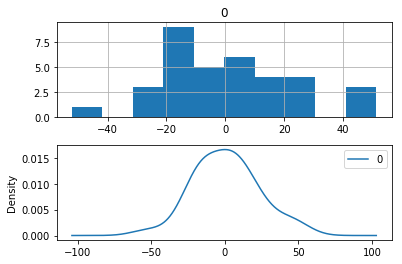

In [26]:
# summarize residual errors for an ARIMA model
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

We could use this information to bias-correct predictions by adding the mean residual error of 1.0816 to each forecast made.

The performance of the predictions is improved very slightly from 21.733 to 21.706, which may or may not be significant. The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero.

RMSE: 21.706
                  0
count  3.500000e+01
mean  -1.834233e-08
std    2.202257e+01
min   -5.318543e+01
25%   -1.728391e+01
50%   -1.541424e+00
75%    1.100347e+01
max    5.020271e+01


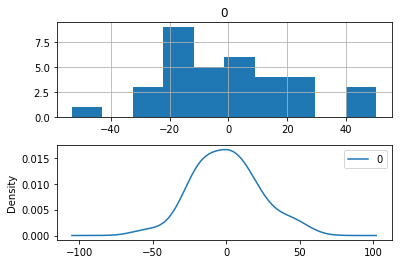

In [27]:
# summarize residual errors from bias corrected forecasts
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 1.081623
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = bias + float(model_fit.forecast()[0])
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot residual errors
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

In [28]:
email_notify("Residual Errors Review completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [29]:
email_notify("Model Fitting and Evaluation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 5. Finalize and Deploy Model

After models have been developed and a final model selected, it must be validated and finalized. Validation is an optional part of the process, but one that provides a ‘last check’ to ensure we have not fooled or lied to ourselves.

This section includes the following steps:

* Finalize Model: Train and save the final model.
* Make Prediction: Load the finalized model and make a prediction.
* Validate Model: Load and validate the final model.

In [30]:
email_notify("Model Finalization and Deployment has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Finalize Model

Finalizing the model involves fitting an ARIMA model on the entire dataset, in this case, on a transformed version of the entire dataset. Once fit, the model can be saved to file for later use.

The code below trains an ARIMA(2,1,0) model on the dataset and saves the whole fit object and the bias to file. Running the code creates two local files:

* model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes the coefficients and all other internal data returned when fitting the model.
* model_bias.npy This is the bias value stored as a one-row, one-column NumPy array.

In [31]:
# save finalized model to file
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 1.081623
# save model
model_fit.save('model.pkl')
np.save('model_bias.npy', [bias])

### 5.b) Make Prediction

A natural case may be to load the model and make a single forecast. This is relatively straightforward and involves restoring the saved model and the bias and calling the forecast() function.

Running the example prints the prediction of about 540. If we peek inside validation.csv, we can see that the value on the first row for the next time period is 568. The prediction is in the right ballpark.

In [32]:
# load finalized model and make a prediction
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 540.013


### 5.c) Validate Model

We can load the model and use it in a pretend operational manner. In the test harness section, we saved the final 10 years of the original dataset in a separate file to validate the final model.

We can load this validation.csv file now and use it to see how well our model really is on “unseen” data. There are two ways we might proceed:

* Load the model and use it to forecast the next 10 years. The forecast beyond the first one or two years will quickly start to degrade in skill.
* Load the model and use it in a rolling-forecast manner, updating the transform and model for each time step. This is the preferred method as it is how one would use this model in practice as it would achieve the best performance.

As with model evaluation in the previous sections, we will make predictions in a rolling-forecast manner. This means that we will step over lead times in the validation dataset and take the observations as an update to the history.

The final RMSE for the validation period is predicted at 16 liters per capita per day. This is not too different from the expected error of 21, but we would expect that it is also not too different from a simple persistence model. The forecast does have the characteristics of a persistence forecast. This suggests that although this time series does have an obvious trend, it is still a reasonably difficult problem.

>Predicted=540.013, Expected=568
>Predicted=571.589, Expected=575
>Predicted=573.289, Expected=579
>Predicted=579.561, Expected=587
>Predicted=588.063, Expected=602
>Predicted=603.022, Expected=594
>Predicted=593.178, Expected=587
>Predicted=588.558, Expected=587
>Predicted=588.797, Expected=625
>Predicted=627.941, Expected=613
RMSE: 16.532


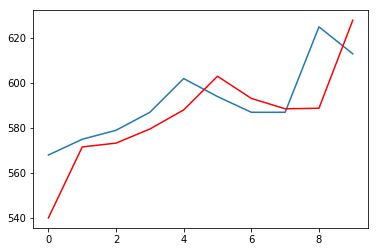

In [33]:
# load and evaluate the finalized model on the validation dataset
# load and prepare datasets
X = dataset.values.astype('float32')
history = [x for x in X]
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = bias + float(model_fit.forecast()[0])
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

In [34]:
email_notify("Model Finalization and Deployment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [35]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:02:28.731032
